# QR decompostion and the coherence matrix

This notebbook was the first attempt at getting some intuition into why approximating the eigenvalue decomposition of a coherence matrix using QR decompsition is a good idea.

The proposed idea for using QR decomposition to approximate the eigenvalue decomposition of a coherence matrix is as follows:
- Given a matrix $U$ with $n$ columns corresponding to a discrete frequency of the fourier transform of $n$ time windows, we can compute the coherence matrix $C = |UU^H|^2$. The first step of the approximation is to compute the QR decomposition of $$U = QR$$
- Then the eigenvalues of the coherence matrix are approximated by the eigenvalues of the matrix $$RR^H$$

## Ideas explored in this notebook
- Geometric distribution of the $U$ matrix
- The R matrix of the QR decomposition of $U$
- How random noise affects the QR approximation of eigenvalues of the coherence matrix
- Assumptions made in the QR approximation
    - eigenvalues of $RR^H$ are close to the eigenvalues of $|UU^H|^2$
    - eigenvalues of $RR^H$ are close to the diagonal of $R^HR$

In [43]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import time
# from sklearn.utils.extmath import randomized_svd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

import sys
sys.path.append('../')
import functions as f

Load data

In [44]:
# file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083818.h5"
# data3,_ = loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data,_ = f.loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data2,_= f.loadBradyHShdf5(file,normalize='no')

# signalToUse=np.append(data[:,24976:],data2[:,:10000],axis=1)
data = np.append(data,data2,axis=1)
# data = np.append(data,data3,axis=1)
samples_per_sec=1000

Define coherence analyses parameters.

In [45]:
# start_ch = 1000
# nchannels = 3000
# start_ch = 4500
# nchannels = 1000
start_ch = 3100
nchannels = 2000
nsensors = 200
subwindow_len = 2
overlap = 0

Plot data

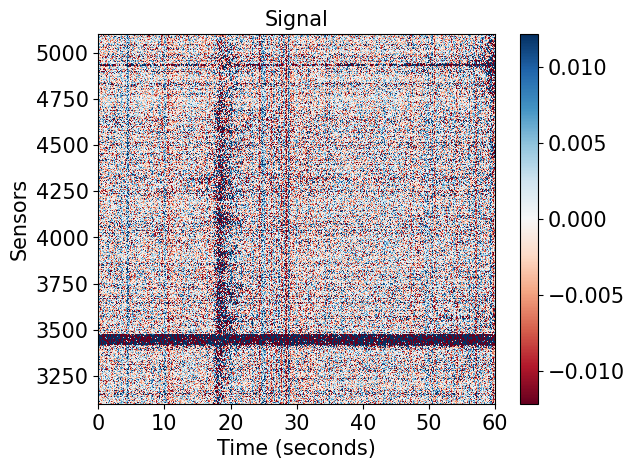

In [46]:
fsize=15
# pdata=data [:,25000:] # signalToUse[1900:3900]
# pdata = data[start_ch:nchannels+start_ch,25000:]
pdata = data[start_ch:nchannels+start_ch]

fig2 = plt.figure()
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, start_ch, start_ch + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Signal',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

Compute the coherence matrix

In [47]:
norm_win_spectra, frequencies = f.normalised_windowed_spectra(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], subwindow_len, overlap, sample_interval=0.001)
# norm_win_spectra, frequencies = normalised_windowed_spectra(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], 5, 2.5, sample_interval=0.001)

# welch_coherence = np.matmul(norm_win_spectra.transpose(2,1,0), np.conjugate(norm_win_spectra.transpose(2,0,1)))
welch_coherence_mat = np.matmul(norm_win_spectra, np.conjugate(norm_win_spectra.transpose(0,2,1)))
welch_coherence_mat = np.absolute(welch_coherence_mat)**2

### Compute and visualize detection parameter across various frequencies

To begin getting a computational intuition into the first assumption, we will compute the detection with eigenvalues of the coherence matrix, the proposed QR approximation and the eigenvalues of the matrix $RR^H$.


In [89]:
fsize = 15

num_frames = int(welch_coherence_mat.shape[0]/2)

eig_ratios = np.empty(num_frames)
eig_ratios_qr = np.empty(num_frames)
eig_ratios_qr2 = np.empty(num_frames)
eig_ratios_qr_diag = np.empty(num_frames)
eig_ratios_qr2_diag = np.empty(num_frames)
eig_RRH_ratios = np.empty(num_frames)
RRH_diagonality = np.empty(num_frames)

for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(welch_coherence_mat[d*2])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios[d] = eigenvals[0]/np.sum(eigenvals)

    Q,R = np.linalg.qr(norm_win_spectra[d*2])
    RRH = np.absolute(R@np.conjugate(R.transpose()))
    qr_approx = np.sort(np.sum(RRH, axis=0))[::-1]
    qr_approx_diag = np.sort(np.diag(RRH))[::-1]
    eigs_RRH, _ = np.linalg.eig(RRH)
    eigs_RRH = np.sort(eigs_RRH)[::-1]
    eig_RRH_ratios[d] = eigs_RRH[0]/np.sum(eigs_RRH)

    RRH_diagonality[d] = np.sum(np.diag(RRH))/np.sum(RRH)

    eig_ratios_qr[d] = qr_approx[0]/np.sum(np.absolute(qr_approx))
    eig_ratios_qr_diag[d] = qr_approx_diag[0]/np.sum(np.absolute(qr_approx_diag))

    Q,R = np.linalg.qr(norm_win_spectra[d*2].T)
    qr_approx2_diag = np.sort(np.diag(np.absolute(R@R.transpose())))[::-1]
    qr_approx2 = np.sort(np.sum(np.absolute(R@R.transpose()), axis=0))[::-1]
    # qr_approx = np.sort(np.sum(R@R.transpose(), axis=0))[::-1]
    eig_ratios_qr2[d] = qr_approx2[0]/np.sum(np.absolute(qr_approx2))
    eig_ratios_qr2_diag[d] = qr_approx2_diag[0]/np.sum(np.absolute(qr_approx2_diag))

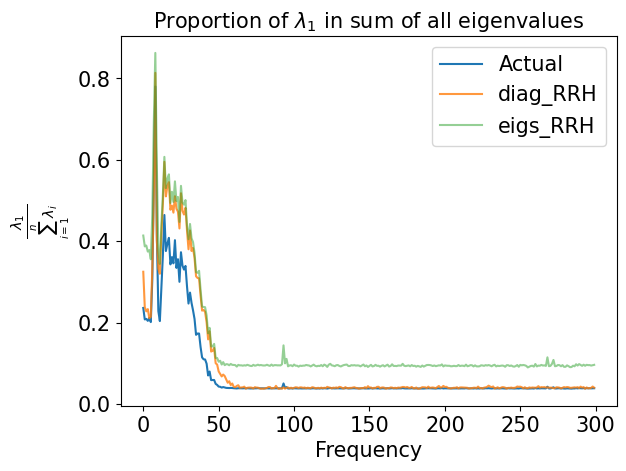

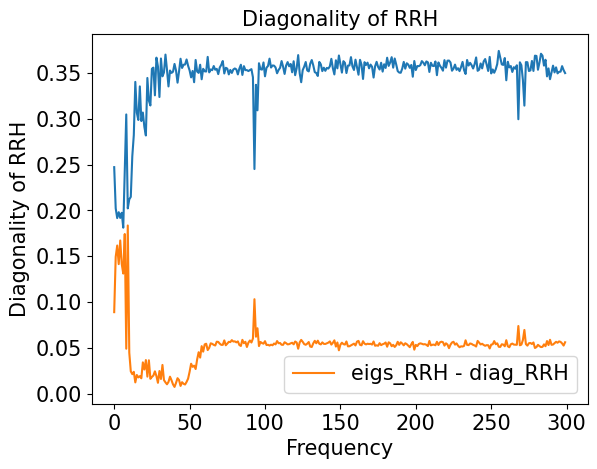

In [91]:
# plot_freqs = frequencies[:num_frames]
plot_freqs = frequencies[2*np.array(range(num_frames))]
end_freq = int(0.6*num_frames)
plt.plot(plot_freqs[:end_freq], eig_ratios[:end_freq], label="Actual")
# plt.plot(plot_freqs[:end_freq], eig_ratios_qr[:end_freq], label="QR",alpha=0.8)
# plt.plot(frequencies[:num_frames], eig_ratios_qr2, label="QR2",alpha=0.6)
plt.plot(plot_freqs[:end_freq], eig_ratios_qr_diag[:end_freq], label="diag_RRH",alpha=0.8)
plt.plot(plot_freqs[:end_freq], eig_RRH_ratios[:end_freq], label="eigs_RRH",alpha=0.5)
# plt.plot(frequencies[:num_frames], eig_ratios_qr2_diag, label="QR2_diag",alpha=0.6)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize)

plt.figure()
# plt.plot(plot_freqs[:end_freq], eig_ratios[:end_freq], label="Actual")
# plt.plot(plot_freqs[:end_freq], eig_RRH_ratios[:end_freq], label="eigs_RRH",alpha=0.5)
plt.plot(plot_freqs[:end_freq], RRH_diagonality[:end_freq])
plt.plot(plot_freqs[:end_freq], eig_RRH_ratios[:end_freq] - eig_ratios_qr_diag[:end_freq], label="eigs_RRH - diag_RRH")
plt.ylabel("Diagonality of RRH",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.title("Diagonality of RRH",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize)

Investigate the angle between the eigenvectors of the coherence matrix and the QR approximation

In [96]:
num_frames = int(welch_coherence_mat.shape[0]/2)
num_subwindows = norm_win_spectra.shape[2]

# angles_eig_RRH = np.empty((num_frames, num_subwindows))
angles_Q_eig = np.empty((num_frames, num_subwindows))

for d in range(num_frames):
    _, eig_vecs = np.linalg.eig(welch_coherence_mat[d*2])
    order_eig = np.argsort(np.abs(_))[::-1]

    Q,R = np.linalg.qr(norm_win_spectra[d*2])
    RRH = np.absolute(R@np.conjugate(R.transpose()))
    order_Q = np.argsort(np.diag(RRH))[::-1]
    for s in range(num_subwindows):
        angles_Q_eig[d,s] = np.arccos(np.abs(np.sum(eig_vecs[:,order_eig[s]]*np.absolute(Q[:,order_Q[s]])))) #/np.linalg.norm(eig_vecs[:,0])/np.linalg.norm(Q[:,0]))
        # _, eig_vecs_RRH = np.linalg.eig(RRH)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500')])

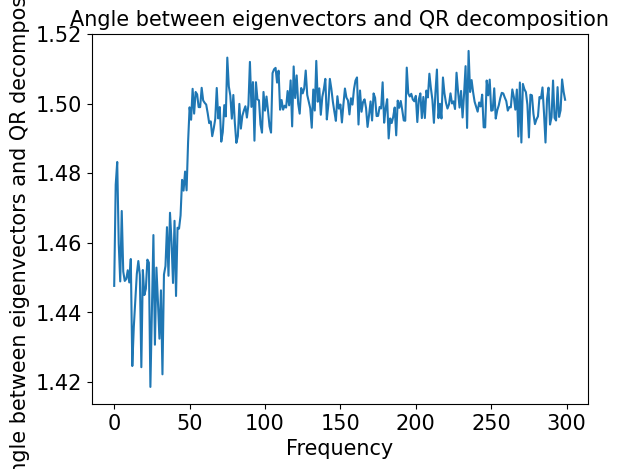

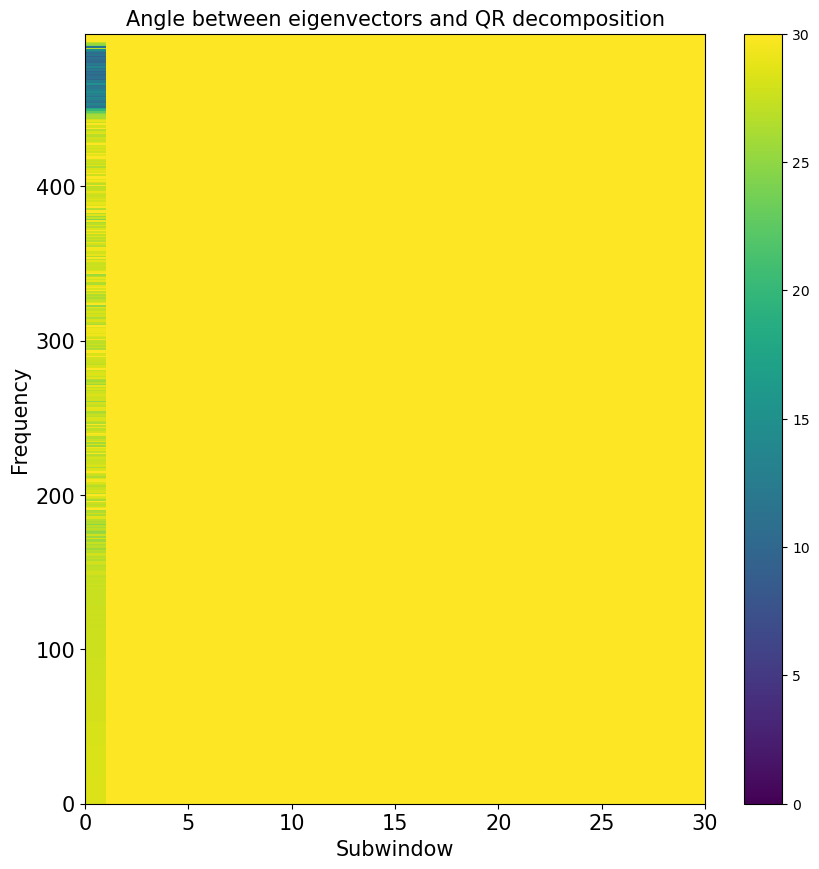

In [99]:
plt.figure()
plt.plot(plot_freqs[:end_freq], np.mean(angles_Q_eig,axis=1)[:end_freq])
plt.ylabel("Angle between eigenvectors and QR decomposition",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.title("Angle between eigenvectors and QR decomposition",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

plt.figure(figsize=(10,10))
plt.imshow(angles_Q_eig * (180/np.pi), aspect='auto', interpolation='none', vmin=0, vmax=30, extent=(0, num_subwindows, plot_freqs[0], plot_freqs[-1]))
plt.colorbar()
plt.ylabel("Frequency",fontsize=fsize)
plt.xlabel("Subwindow",fontsize=fsize)
plt.title("Angle between eigenvectors and QR decomposition",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

Text(0.5, 0, 'Frequency')

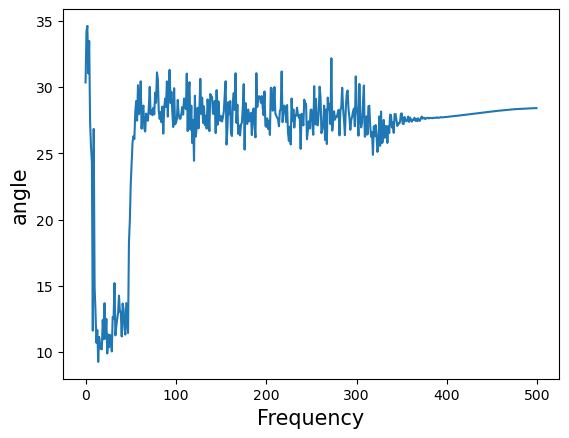

In [105]:
plt.plot(angles_Q_eig[:,0] * (180/np.pi))
plt.ylabel("angle",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)

In doing coherence analysis, we are assuming that the first eigenvector of the coherence matrix corresponds to a direction that represents the signal of interest. In using the QR approximation, we are assuming that this direction can be well-approximated by the column in $U$ associated with the onset of the signal of interest.

Display coherence matrix at a particular frequency.

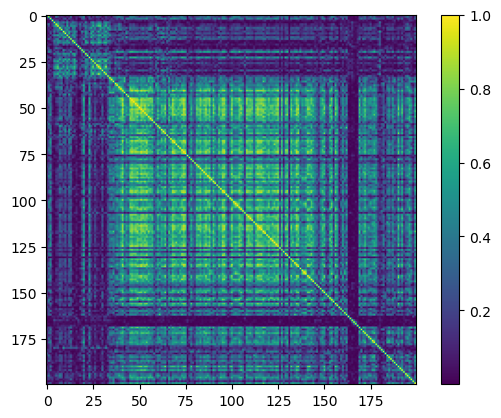

In [28]:
# welch_coherence_mat.shape
plt.imshow(welch_coherence_mat[30,:,:].real)
plt.colorbar()

Compare methods of approximating eigen values do with a general timing test with random data.

In [34]:
RandA = norm_win_spectra[34,:,:]
nreps = 10

t0 = time.time()
for i in range(nreps):
    Q,R = np.linalg.qr(RandA)
    # qr_approx2 = np.sum(np.absolute(R@R.transpose()), axis=0)**2
    # qr_approx = np.diag(np.absolute(R@R.transpose()))**2
    eig_RRH, _ = np.linalg.eig(R@R.transpose().conj())
    diag_RRH = np.diag(np.absolute(R@R.transpose()))

    Q2,R2 = np.linalg.qr(RandA.T)
    # qr_approx2 = np.diag(np.absolute(R2@R2.transpose())) #**2
t1 = time.time()
qr_time = t1-t0
print("QR time: ", qr_time)

t0 = time.time()
for i in range(nreps):
    coherence_mat = np.absolute(RandA@np.conjugate(RandA.transpose()))**2
    eigenvals, _ = np.linalg.eig(coherence_mat)
t1 = time.time()
eig_time = t1-t0

print("Eigenvalue time: ", eig_time)

QR time:  0.0390012264251709
Eigenvalue time:  0.5989992618560791


Plot the estimated eigen values.

c:\Users\issah\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning:

Casting complex values to real discards the imaginary part



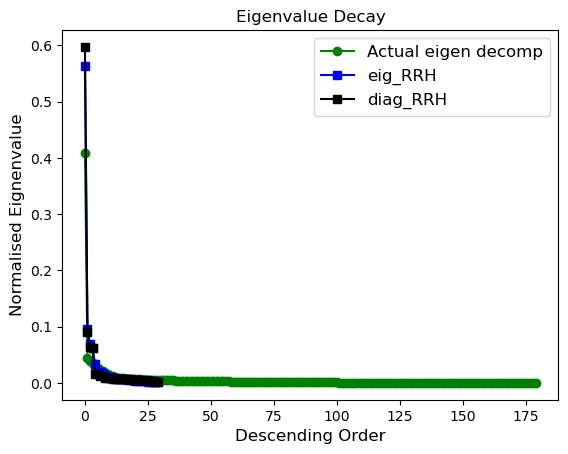

In [35]:
fsize = 12
eig_RRH = np.sort(eig_RRH)[::-1]
diag_RRH = np.sort(diag_RRH)[::-1]
# qr_approx = np.sort(np.sum(R@R.transpose(), axis=0))[::-1]
eig_RRH = eig_RRH/np.sum(np.absolute(eig_RRH))
diag_RRH = diag_RRH/np.sum(np.absolute(diag_RRH)) 

actual_eigenval = np.sort(eigenvals)[::-1]
actual_eigenval = actual_eigenval/np.sum(actual_eigenval)

plt.plot(actual_eigenval[:6*len(qr_approx)], "g-o", label="Actual eigen decomp")
plt.plot(eig_RRH, "b-s", label="eig_RRH")
plt.plot(diag_RRH, "k-s", label="diag_RRH")

plt.xlabel('Descending Order',fontsize=fsize)
plt.ylabel('Normalised Eignenvalue',fontsize=fsize)
plt.title('Eigenvalue Decay',fontsize=fsize)
# plt.yscale('log')
plt.legend(fontsize=fsize)

## Distribution of points in space

Plot various columns of the coherence matrix to get a feel of the distribution of these points in space. The idea is to see if most of the points are clustered in any particular direction. This can be done easily if we have 2 dimensions. Since we do not have that luxurry, the next couple of cells will try to get some intuition into the distribution of the points in space by plotting in different ways.

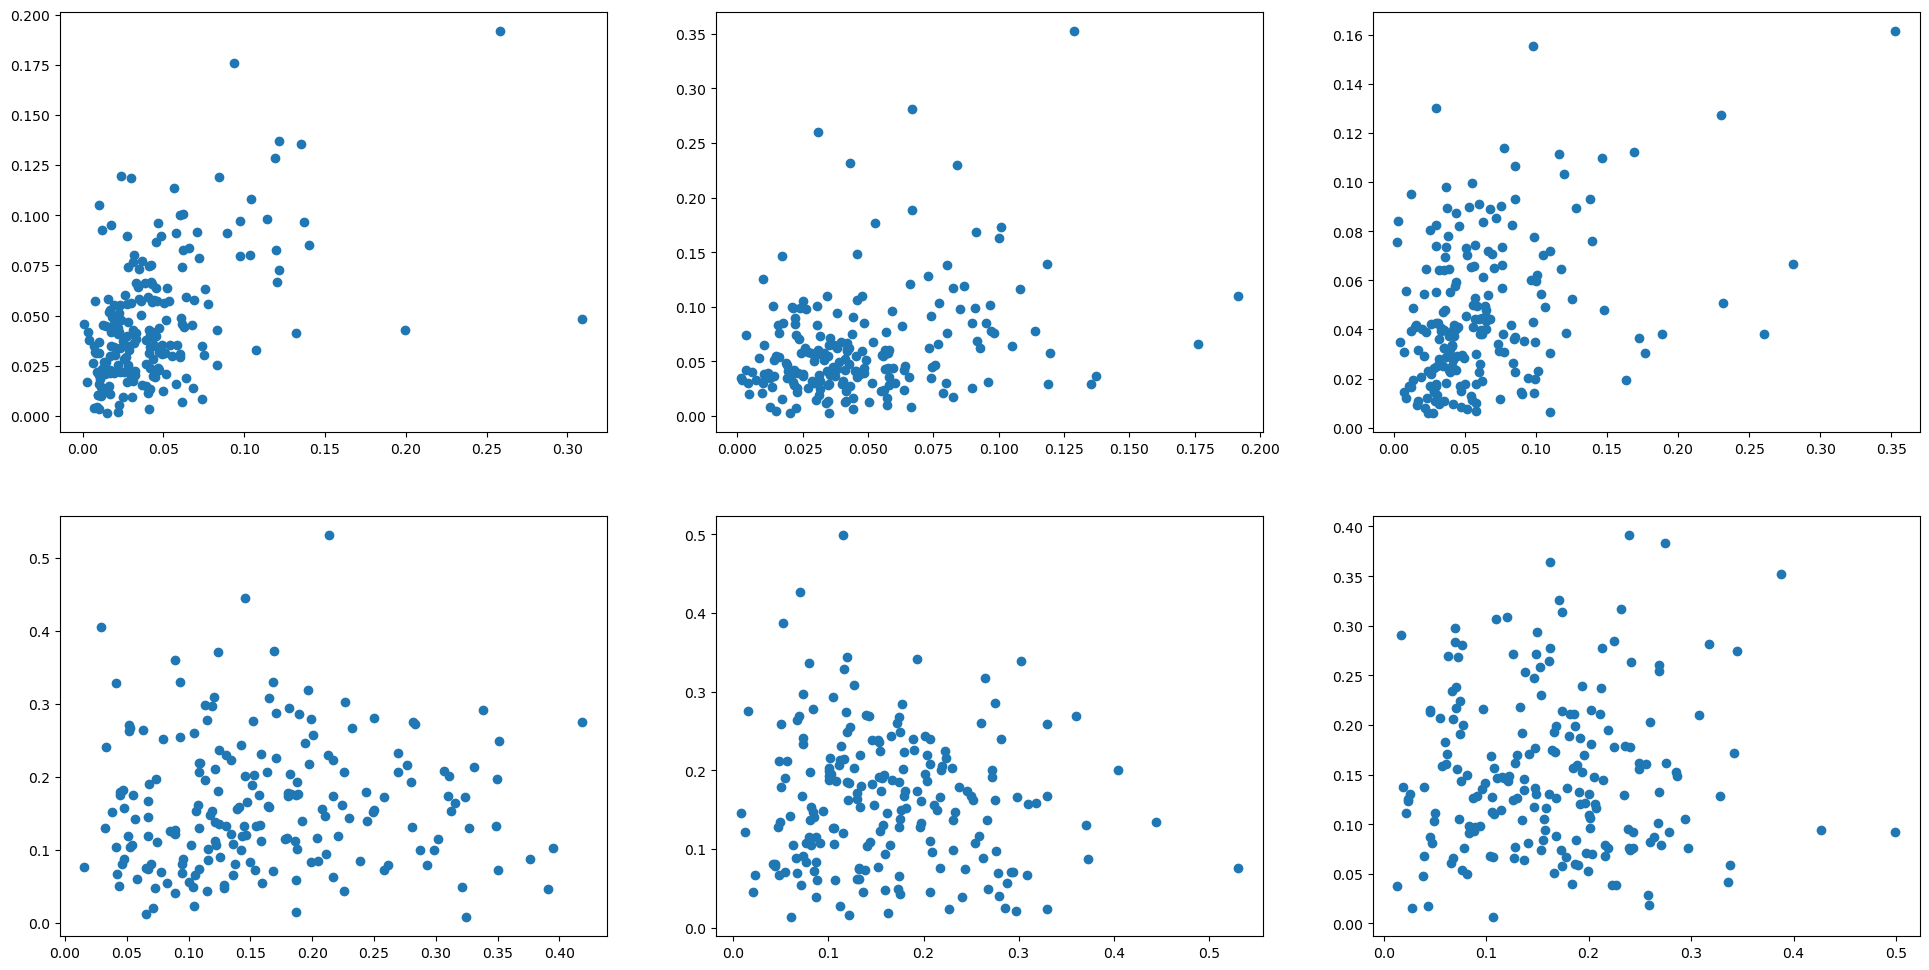

In [12]:
# plt.matshow(np.log10(welch_coherence_mat[0,:,:]))
# plt.matshow(np.abs(norm_win_spectra[0,:,:]))
f_index = 30
shift = 1

plt.figure(figsize=(24,12))
plt.subplot(2,3,1)
plt.plot(np.abs(norm_win_spectra[f_index,:,3])*shift, np.abs(norm_win_spectra[f_index,:,4])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,2)
plt.plot(np.abs(norm_win_spectra[f_index,:,4])*shift, np.abs(norm_win_spectra[f_index,:,5])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,3)
plt.plot(np.abs(norm_win_spectra[f_index,:,5])*shift, np.abs(norm_win_spectra[f_index,:,6])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)

f_index = 400
plt.subplot(2,3,4)
plt.plot(np.abs(norm_win_spectra[f_index,:,3])*shift, np.abs(norm_win_spectra[f_index,:,4])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,5)
plt.plot(np.abs(norm_win_spectra[f_index,:,4])*shift, np.abs(norm_win_spectra[f_index,:,5])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,6)
plt.plot(np.abs(norm_win_spectra[f_index,:,5])*shift, np.abs(norm_win_spectra[f_index,:,6])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)

Make a 3D plot of some columns the coherence matrix.

In [13]:
f_index = 30
shift = 1

# Create a list of vectors
vectors = [
    np.array([1, 2, 3]),
    np.array([4, 5, 6]),
    np.array([7, 8, 9]),
    # Add more vectors as needed
]

points = np.abs(norm_win_spectra[f_index,:,(4,5,6)])*shift
vectors = points.T

# Extract coordinates from vectors
x_coords = [vector[0] for vector in vectors]
y_coords = [vector[1] for vector in vectors]
z_coords = [vector[2] for vector in vectors]

# Create a 3D scatter plot
fig = go.Figure()

# Add scatter points for each vector
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers'))

# Set layout properties
fig.update_layout(scene=dict(aspectmode="cube", xaxis=dict(title="X"), yaxis=dict(title="Y"), zaxis=dict(title="Z")),
                  margin=dict(l=0, r=0, b=0, t=0))



Plot the approximation of the eigenvalues using the QR decomposition of $U$ and $U^T$. 

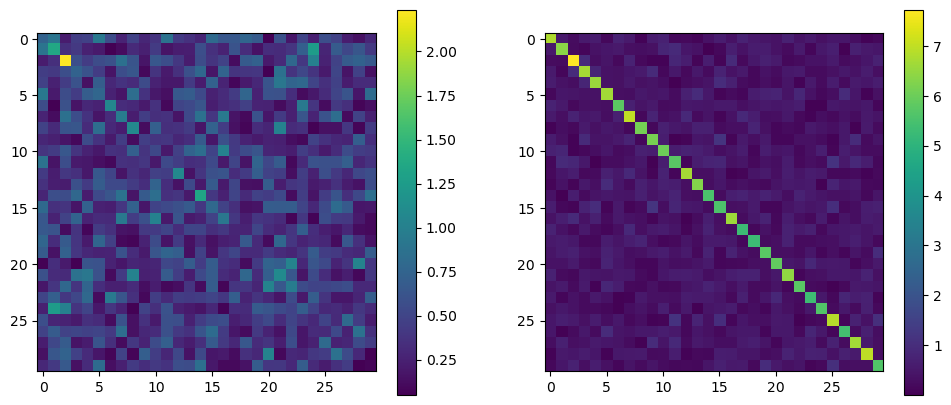

In [14]:
RandA = norm_win_spectra[400,:,:]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
Q1,R1 = np.linalg.qr(RandA.T)
# plt.matshow(np.abs(R1@R1.T))
plt.imshow(np.abs(R1@R1.T))
plt.colorbar()
plt.subplot(1,2,2)
Q1,R1 = np.linalg.qr(RandA)
plt.imshow(np.abs(R1@R1.T))
plt.colorbar()
# plt.subplot(1,3,3)

0.04170708171855681


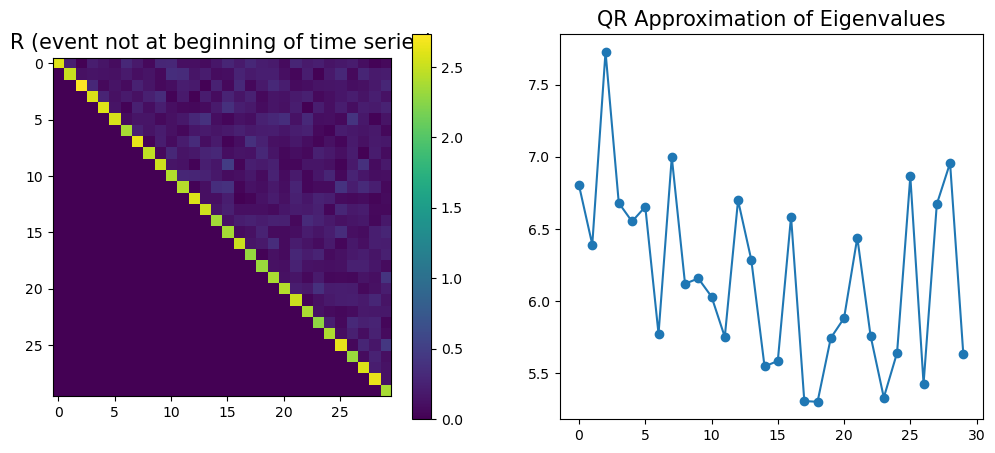

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(np.abs(R1))
plt.colorbar()
plt.title('R (event not at beginning of time series)', fontsize=15)
plt.subplot(1,2,2)
# plt.plot(frequencies)
qr_ = np.diag(np.absolute(R1@R1.transpose()))
plt.plot(qr_, '-o')
plt.title('QR Approximation of Eigenvalues', fontsize=15)
print(np.max(qr_)/np.sum(np.absolute(qr_)))

0.062471654728826397


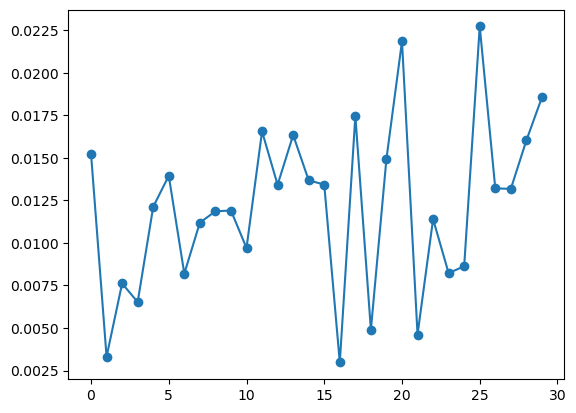

In [16]:
# for a in range(RandA.shape[1]):
# for a in range(10, 16):
#     plt.plot(np.abs(RandA[:,a]), label=str(a))

# plt.legend()
mean_RandA = np.abs(np.mean(RandA, axis=0))
plt.plot(np.abs(np.mean(RandA, axis=0)), '-o')
print(np.max(mean_RandA)/np.sum(np.absolute(mean_RandA)))

Test to see if the amount of enery within $U$ is enough to approximate the detection which would otherwise be done with the eigenvalues of the coherence matrix.

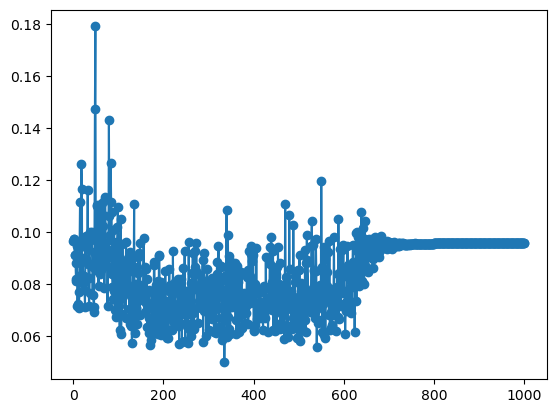

In [17]:
apprxs = []
for a in range(len(norm_win_spectra)):
    mean_ = np.abs(np.mean(norm_win_spectra[a,:,:], axis=0))
    apprxs.append(np.max(mean_)/np.sum(np.absolute(mean_)))

plt.plot(apprxs, '-o')

Find the angles between the columns of the $U$ matrix.

C:\Users\issah\AppData\Local\Temp\ipykernel_24372\1515664698.py:8: RuntimeWarning:

invalid value encountered in arccos



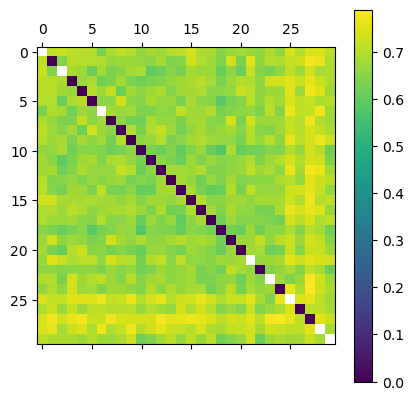

In [18]:
f_index = 400
wins = norm_win_spectra.shape[2]
angles = np.zeros((wins,wins))
for i in range(wins):
    for j in range(wins):
        # angles[i,j] = np.arccos(np.dot(norm_win_spectra[f_index,:,i], norm_win_spectra[f_index,:,j])/(np.linalg.norm(norm_win_spectra[f_index,:,i])*np.linalg.norm(norm_win_spectra[f_index,:,j])))
        # angles[i,j] = np.dot(norm_win_spectra[f_index,:,i], norm_win_spectra[f_index,:,j])/(np.linalg.norm(norm_win_spectra[f_index,:,i])*np.linalg.norm(norm_win_spectra[f_index,:,j]))
        angles[i,j] = np.arccos(np.dot(np.absolute(norm_win_spectra[f_index,:,i]), np.absolute(norm_win_spectra[f_index,:,j]))/(np.linalg.norm(np.absolute(norm_win_spectra[f_index,:,i]))*np.linalg.norm(np.absolute(norm_win_spectra[f_index,:,j]))))

plt.matshow(angles)
plt.colorbar()

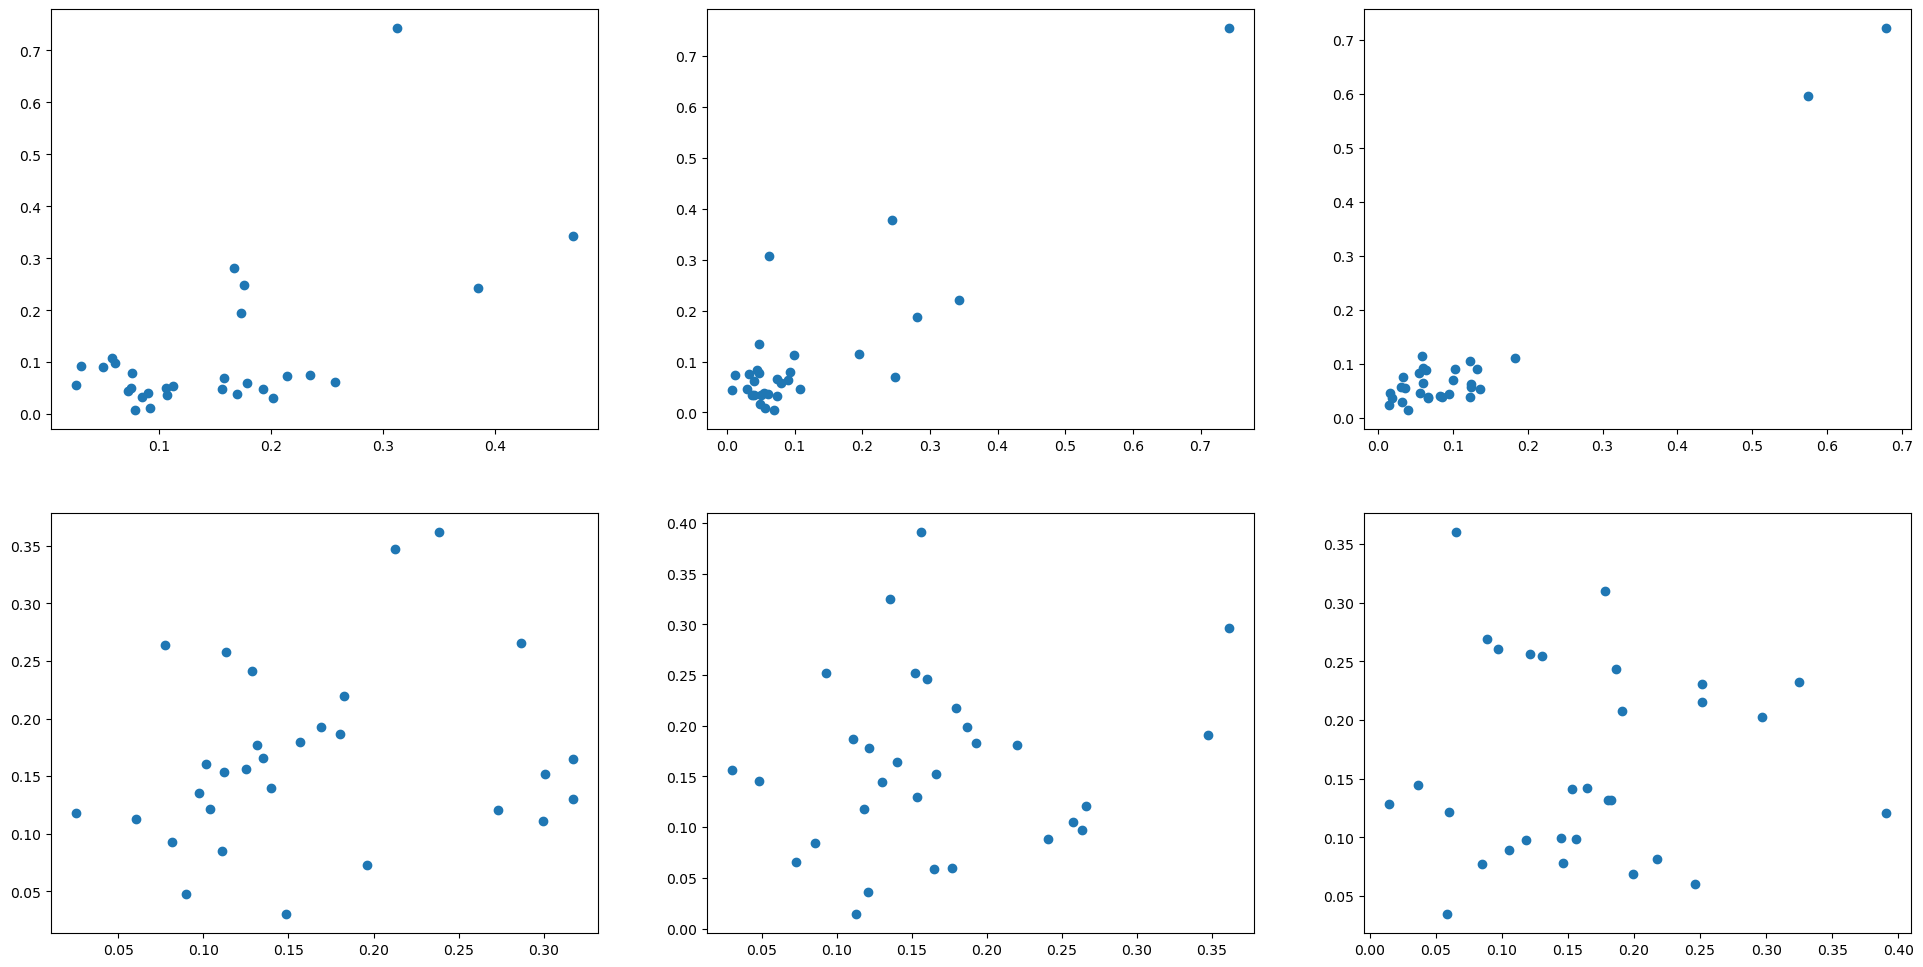

In [19]:
# plt.matshow(np.log10(welch_coherence_mat[0,:,:]))
# plt.matshow(np.abs(norm_win_spectra[0,:,:]))
f_index = 30
shift = 1

plt.figure(figsize=(24,12))
plt.subplot(2,3,1)
plt.plot(np.abs(norm_win_spectra[f_index,3,:])*shift, np.abs(norm_win_spectra[f_index,4,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,2)
plt.plot(np.abs(norm_win_spectra[f_index,4,:])*shift, np.abs(norm_win_spectra[f_index,5,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,3)
plt.plot(np.abs(norm_win_spectra[f_index,10,:])*shift, np.abs(norm_win_spectra[f_index,12,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)

f_index = 400
plt.subplot(2,3,4)
plt.plot(np.abs(norm_win_spectra[f_index,3,:])*shift, np.abs(norm_win_spectra[f_index,4,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,5)
plt.plot(np.abs(norm_win_spectra[f_index,4,:])*shift, np.abs(norm_win_spectra[f_index,5,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,6)
plt.plot(np.abs(norm_win_spectra[f_index,5,:])*shift, np.abs(norm_win_spectra[f_index,6,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)

In [20]:
f_index = 30
shift = 1

# Create a list of vectors
vectors = [
    np.array([1, 2, 3]),
    np.array([4, 5, 6]),
    np.array([7, 8, 9]),
    # Add more vectors as needed
]

points = np.abs(norm_win_spectra[f_index,(4,5,6),:])*shift
vectors = points.T

# Extract coordinates from vectors
x_coords = [vector[0] for vector in vectors]
y_coords = [vector[1] for vector in vectors]
z_coords = [vector[2] for vector in vectors]

# Create a 3D scatter plot
fig = go.Figure()

# Add scatter points for each vector
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers'))

# Set layout properties
fig.update_layout(scene=dict(aspectmode="cube", xaxis=dict(title="X"), yaxis=dict(title="Y"), zaxis=dict(title="Z")),
                  margin=dict(l=0, r=0, b=0, t=0))

### Add random noise to the data and see how the approximation of the eigenvalues of the coherence matrix using the QR decomposition of $U$ is affected.

c:\Users\issah\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning:

Casting complex values to real discards the imaginary part



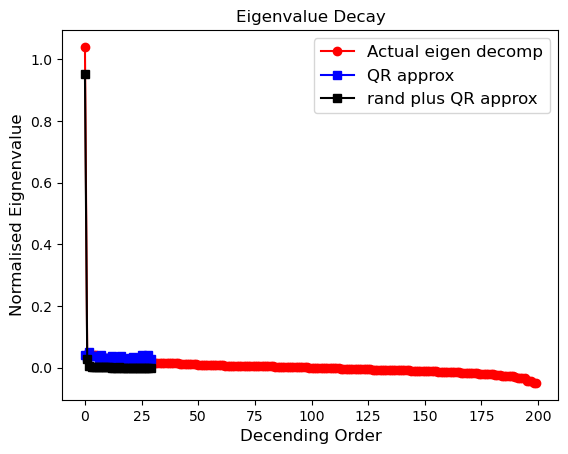

In [21]:
# random matrix with same size as norm_win_spectra
random_A = np.random.rand(*norm_win_spectra.shape)
random_A = random_A + 1j*np.random.rand(*norm_win_spectra.shape) + norm_win_spectra
RandAa = random_A[350,:,:]
welch_coherence_mat_rand = np.absolute(RandAa@np.conjugate(RandA.transpose()))**2

eigenvals, _ = np.linalg.eig(welch_coherence_mat_rand)
eigenvals = np.sort(eigenvals)[::-1]
eigenvals = eigenvals/np.sum(eigenvals)

welch_coherence_mat_rand = np.absolute(RandAa@np.conjugate(RandA.transpose()))**2

rand_eigenvals, _ = np.linalg.eig(welch_coherence_mat_rand)
rand_eigenvals = np.sort(rand_eigenvals)[::-1]
rand_eigenvals = rand_eigenvals/np.sum(rand_eigenvals)


Q,R = np.linalg.qr(RandA)
# qr_approx2 = np.sum(np.absolute(R@R.transpose()), axis=0)**2
qr_approx = np.diag(np.absolute(R@R.transpose()))**2
qr_approx = qr_approx/np.sum(np.absolute(qr_approx))

Q,R = np.linalg.qr(RandAa)
# qr_approx2 = np.sum(np.absolute(R@R.transpose()), axis=0)**2
qr_approx_rand = np.diag(np.absolute(R@R.transpose()))**2
qr_approx_rand = qr_approx_rand/np.sum(np.absolute(qr_approx_rand))

# rand_qr_approx = np.diag(np.absolute(
plt.plot(eigenvals, "r-o", label="Actual eigen decomp")
# plt.plot(rand_eigenvals, "g-o", label="rand plus Actual eigen decomp")
plt.plot(qr_approx, "b-s", label="QR approx")
plt.plot(qr_approx_rand, "k-s", label="rand plus QR approx")
plt.xlabel('Decending Order',fontsize=fsize)
plt.ylabel('Normalised Eignenvalue',fontsize=fsize)
plt.title('Eigenvalue Decay',fontsize=fsize)
plt.legend(fontsize=fsize)

In [22]:
fsize = 15
# num_frames = coherence2.shape[0]
# data_2use = welch_coherence_mat.real
# data_2use = np.absolute(welch_coherence_mat)**2
# num_frames = int(data_2use.shape[0]/2)

num_frames = int(norm_win_spectra.shape[0]/2)

eig_ratios2 = np.empty(num_frames)
eig_ratios_qr = np.empty(num_frames)
eig_ratios_qr2 = np.empty(num_frames)
eig_ratios_qr_diag = np.empty(num_frames)
eig_ratios_qr2_diag = np.empty(num_frames)
eig_ratios_qr_rand = np.empty(num_frames)
eig_ratios_svd = np.empty(num_frames)
eig_ratios_rsvd = np.empty(num_frames)
for d in range(num_frames):
    RandA = norm_win_spectra[d*2]
    coherence_mat = np.absolute(RandA@np.conjugate(RandA.transpose()))**2
    eigenvals, _ = np.linalg.eig(coherence_mat)
    # eigenvals, _ = np.linalg.eig(data_2use[d*2])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios2[d] = eigenvals[0]/np.sum(eigenvals)

    Q,R = np.linalg.qr(norm_win_spectra[d*2])
    qr_approx = np.sort(np.sum(np.absolute(R@R.transpose()), axis=0))[::-1]
    qr_approx_diag = np.sort(np.diag(np.absolute(R@R.transpose())))[::-1]
    # qr_approx = np.sort(np.sum(R@R.transpose(), axis=0))[::-1]
    eig_ratios_qr[d] = qr_approx[0]/np.sum(np.absolute(qr_approx))
    eig_ratios_qr_diag[d] = qr_approx_diag[0]/np.sum(np.absolute(qr_approx_diag))

    Q,R = np.linalg.qr(norm_win_spectra[d*2].T)
    qr_approx2_diag = np.sort(np.diag(np.absolute(R@R.transpose())))[::-1]
    # qr_approx2 = np.sort(np.sum(np.absolute(R@R.transpose()), axis=0))[::-1]
    qr_approx2, _ = np.linalg.eig(R@(R.transpose().conj()))
    # qr_approx = np.sort(np.sum(R@R.transpose(), axis=0))[::-1]
    eig_ratios_qr2[d] = qr_approx2[0]/np.sum(np.absolute(qr_approx2))
    eig_ratios_qr2_diag[d] = qr_approx2_diag[0]/np.sum(np.absolute(qr_approx2_diag))

    Q,R = np.linalg.qr(random_A[d*2])
    # qr_approx2 = np.sum(np.absolute(R@R.transpose()), axis=0)**2
    qr_approx_rand = np.diag(np.absolute(R@R.transpose()))**2
    eig_ratios_qr_rand[d] = qr_approx_rand[0]/np.sum(np.absolute(qr_approx_rand))

C:\Users\issah\AppData\Local\Temp\ipykernel_24372\720387363.py:37: ComplexWarning:

Casting complex values to real discards the imaginary part



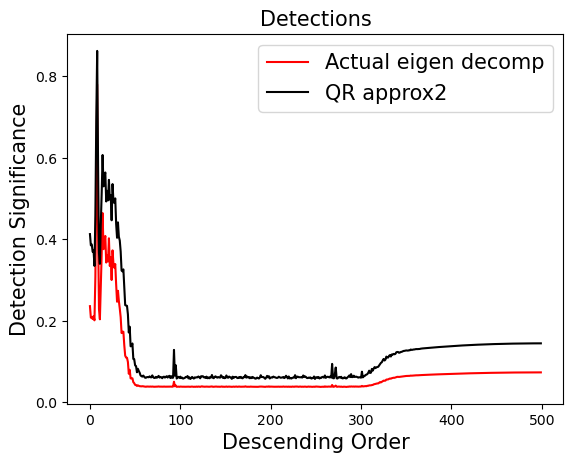

In [23]:
plt.plot(eig_ratios2[:800], "r-", label="Actual eigen decomp")
# plt.plot(eig_ratios_qr[:800], "b-", label="QR approx")
plt.plot(eig_ratios_qr2[:800], "k-", label="QR approx2")
# plt.plot(eig_ratios_qr_diag[:800], "g-", label="QR approx diag")
# plt.plot(eig_ratios_qr2_diag[:800], "y-", label="QR approx2 diag")
# plt.plot(eig_ratios_qr_rand[:800], "m-", label="QR approx rand")

plt.xlabel('Descending Order',fontsize=fsize)
plt.ylabel('Detection Significance',fontsize=fsize)
plt.title('Detections',fontsize=fsize)
plt.legend(fontsize=fsize)